# How you can drive safely in 2020


## KNN Classification


In [2]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [2]:
# read the survey results, slice the states of interests, and display the first 5 rows
df = pd.read_csv('./US_Accidents_May19.csv')
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243939 entries, 0 to 2243938
Data columns (total 49 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float

In [3]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour, weekday and time_duration information
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243939 entries, 0 to 2243938
Data columns (total 55 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float

In [3]:
df.to_csv('./Expanded_May19.csv')

NameError: name 'df' is not defined

In [23]:
df=pd.read_csv('./Expanded_May19.csv')

In [24]:
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset',]

In [25]:
df=df[feature_lst]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2243939 entries, 0 to 2243938
Data columns (total 31 columns):
Source               object
TMC                  float64
Severity             int64
Start_Lng            float64
Start_Lat            float64
Distance(mi)         float64
Side                 object
City                 object
County               object
State                object
Timezone             object
Temperature(F)       float64
Humidity(%)          float64
Pressure(in)         float64
Visibility(mi)       float64
Wind_Direction       object
Weather_Condition    object
Amenity              bool
Bump                 bool
Crossing             bool
Give_Way             bool
Junction             bool
No_Exit              bool
Railway              bool
Roundabout           bool
Station              bool
Stop                 bool
Traffic_Calming      bool
Traffic_Signal       bool
Turning_Loop         bool
Sunrise_Sunset       object
dtypes: bool(13), float64(8), int64(1)

In [26]:
df.to_csv('./Expanded_dropped_May19.csv')

In [27]:
df_PA=df[df.State=='PA']
df_PA.drop('State',axis=1, inplace=True)
df_PA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75814 entries, 197866 to 2243539
Data columns (total 30 columns):
Source               75814 non-null object
TMC                  65699 non-null float64
Severity             75814 non-null int64
Start_Lng            75814 non-null float64
Start_Lat            75814 non-null float64
Distance(mi)         75814 non-null float64
Side                 75814 non-null object
City                 75814 non-null object
County               75814 non-null object
Timezone             75804 non-null object
Temperature(F)       73419 non-null float64
Humidity(%)          73322 non-null float64
Pressure(in)         73724 non-null float64
Visibility(mi)       73323 non-null float64
Wind_Direction       73787 non-null object
Weather_Condition    73327 non-null object
Amenity              75814 non-null bool
Bump                 75814 non-null bool
Crossing             75814 non-null bool
Give_Way             75814 non-null bool
Junction             7581

In [29]:
df_PA.to_csv('./Expanded_dropped_May19_PA.csv')

In [30]:
df_PA_Mont=df_PA[df_PA.County=='Montgomery']
df_PA_Mont.drop('County',axis=1,inplace=True)
df_PA_Mont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26953 entries, 228554 to 2242978
Data columns (total 29 columns):
Source               26953 non-null object
TMC                  26044 non-null float64
Severity             26953 non-null int64
Start_Lng            26953 non-null float64
Start_Lat            26953 non-null float64
Distance(mi)         26953 non-null float64
Side                 26953 non-null object
City                 26953 non-null object
Timezone             26953 non-null object
Temperature(F)       26423 non-null float64
Humidity(%)          26408 non-null float64
Pressure(in)         26563 non-null float64
Visibility(mi)       26362 non-null float64
Wind_Direction       26572 non-null object
Weather_Condition    26355 non-null object
Amenity              26953 non-null bool
Bump                 26953 non-null bool
Crossing             26953 non-null bool
Give_Way             26953 non-null bool
Junction             26953 non-null bool
No_Exit              26953 

In [31]:
df_PA_Mont.to_csv('./Expanded_dropped_May19_PA_Mont.csv')

In [34]:
df_PA_Mont.shape

(26953, 29)

In [37]:
df_PA_Mont.columns[df_PA_Mont.isnull().mean()!=0]

Index(['TMC', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Weather_Condition'],
      dtype='object')

In [41]:
df_PA_Mont.dropna(subset=df_PA_Mont.columns[df_PA_Mont.isnull().mean()!=0],axis=0,inplace=True)
df_PA_Mont.shape

C:\Users\rzhou11\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(25206, 29)

In [43]:
df_PA_Mont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25206 entries, 228554 to 1724934
Data columns (total 29 columns):
Source               25206 non-null object
TMC                  25206 non-null float64
Severity             25206 non-null int64
Start_Lng            25206 non-null float64
Start_Lat            25206 non-null float64
Distance(mi)         25206 non-null float64
Side                 25206 non-null object
City                 25206 non-null object
Timezone             25206 non-null object
Temperature(F)       25206 non-null float64
Humidity(%)          25206 non-null float64
Pressure(in)         25206 non-null float64
Visibility(mi)       25206 non-null float64
Wind_Direction       25206 non-null object
Weather_Condition    25206 non-null object
Amenity              25206 non-null bool
Bump                 25206 non-null bool
Crossing             25206 non-null bool
Give_Way             25206 non-null bool
Junction             25206 non-null bool
No_Exit              25206 

In [45]:
df_PA_Mont_dummy = pd.get_dummies(df_PA_Mont,drop_first=True)
df_PA_Mont_dummy.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25206 entries, 228554 to 1724934
Columns: 133 entries, TMC to Sunrise_Sunset_Night
dtypes: bool(13), float64(8), int64(1), uint8(111)
memory usage: 4.9 MB


In [47]:
df_PA_Mont_dummy.to_csv('./Expanded_dropped_dummy_May19_PA_Mont.csv')

In [52]:
target='Severity'
# Create arrays for the features and the response variable
df=df_PA_Mont_dummy

y = df[target]
X = df.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)


# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

print(knn.score(X_test, y_test))

from sklearn import metrics

print(metrics.accuracy_score(y_test, y_pred))

0.9381116106850039
0.9381116106850039


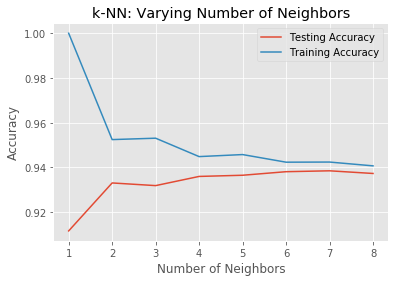

In [53]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


In [55]:

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
      

[[   0    2    0    0]
 [   0 6980   35    0]
 [   0  430  114    0]
 [   0    1    0    0]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.94      1.00      0.97      7015
           3       0.77      0.21      0.33       544
           4       0.00      0.00      0.00         1

    accuracy                           0.94      7562
   macro avg       0.43      0.30      0.32      7562
weighted avg       0.93      0.94      0.92      7562



C:\Users\rzhou11\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 50)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
print('knn_cv.best_params: {}.'.format(knn_cv.best_params_))
print('knn_cv.best_score_: {}.'.format(knn_cv.best_score_))


C:\Users\rzhou11\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


knn_cv.best_params: {'n_neighbors': 6}.
knn_cv.best_score_: 0.9351620947630923.
